In [1]:
import rescomp
import numpy as np
np.random.seed(1)

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

### Hyperparameters:

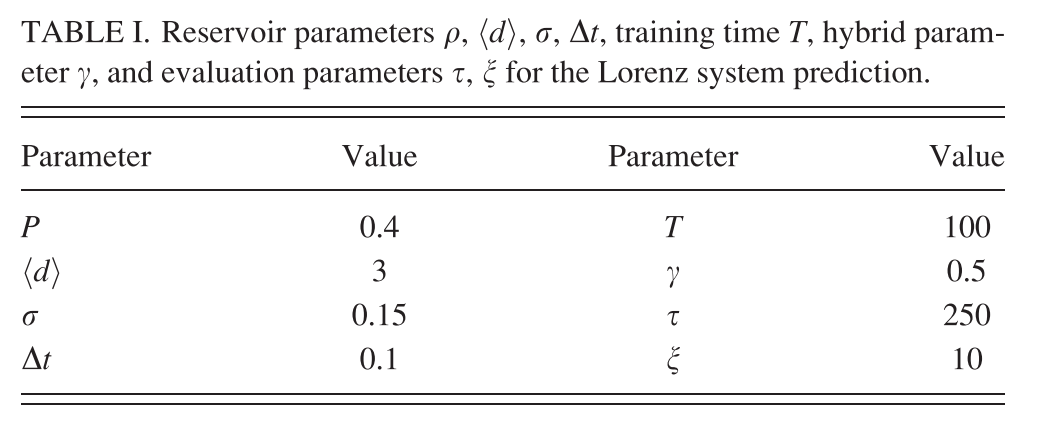

In [2]:
save_results = True

# Measure parameters:
f = 0.4 # error threshhold for valid time t_v
nr_of_time_intervals = 20# 20
nr_of_reailzations = 32# 32


# Lorenz parameters: 
#True dynamical system:
a = 10
b = 28
c = 8/3


#Simulation Parameters:
dt = 0.1
T = 100 # training time
tau = 250 # length of time intervals
xi = 10 # synchronization time
t_d = 50 # Disconnect time (not given in Paper)
t_pre = 50 # Syncing the reservoir before starting to train
starting_point = np.array([-14.03020521, -20.88693127, 25.53545]) #Start point of data (not given in Paper)


# RC:
network_type = "erdos_renyi_directed"
sigma = 0.15
avg_deg = 3
p = 0.4 # largest eigenvalue (spectral radius)
gamma = 0.5 # percentage of res nodes connected to raw input
beta = 1e-5# regularization parameter (not given in Paper)
w_in_sparse = True
w_in_ordered = False
act_fct_flag = "tanh_simple"
w_out_fit_flag = "linear_and_square_r_alt" # "linear_and_square_r_alt"
# w_out_fit_flag = "linear_r" # "linear_and_square_r_alt"


## 1) Simulate the timeseries:
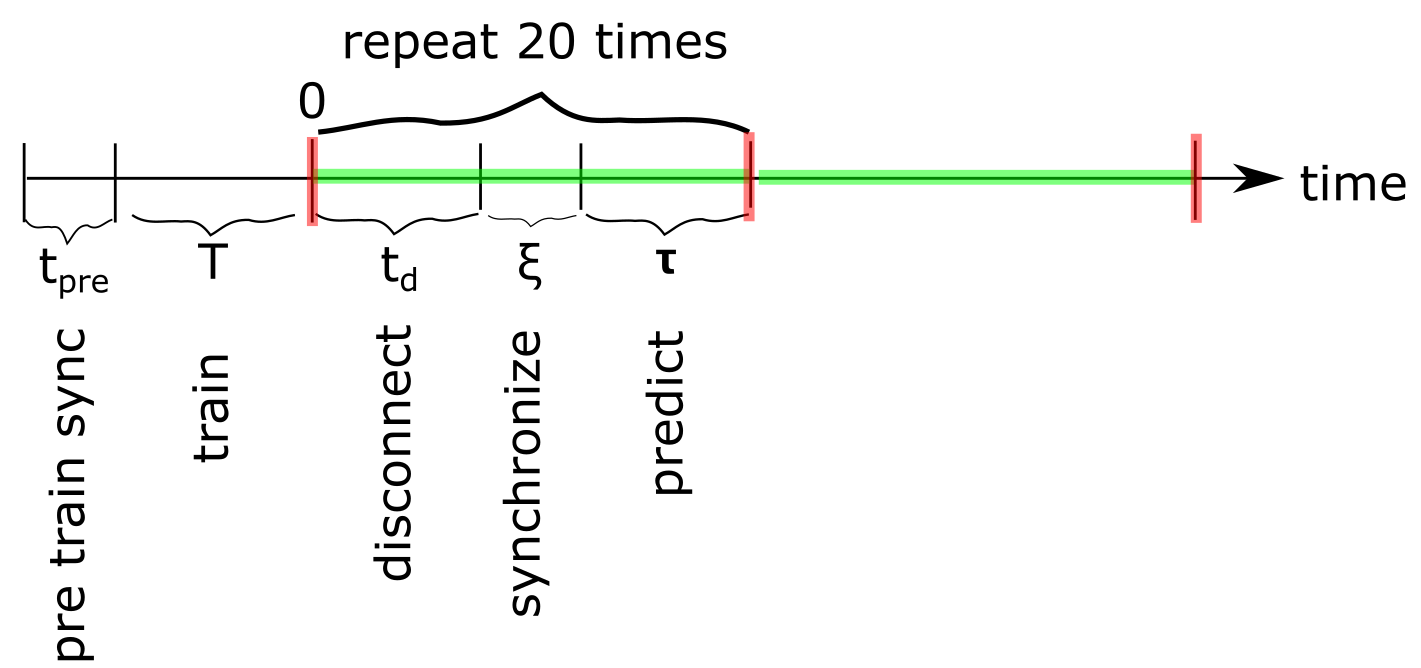

### Create Lorenz Dataset:

In [3]:
# Create Lorenz data set:
pre_train_sync_steps = int(t_pre/dt)
train_steps = int(T/dt)
disconnect_steps = int(t_d/dt)
pre_pred_sync_steps = int(xi/dt)
predict_steps = int(tau/dt)

total_time_steps = pre_train_sync_steps + train_steps + (disconnect_steps + pre_pred_sync_steps + predict_steps)*nr_of_time_intervals

# time_steps = np.arange(-T, (t_d + xi + tau)*nr_of_time_intervals + dt, dt)
# simulation_time_steps = time_steps.size

# Uses runge kutta (not given in paper how trajectory is simulated)
sim_data = rescomp.simulate_trajectory(
    sys_flag='lorenz', dt=dt, time_steps=total_time_steps,
    starting_point=starting_point)

print("sim_data shape: ", sim_data.shape)

x_train = sim_data[:pre_train_sync_steps + train_steps]
print("x_train shape: ", x_train.shape)

x_pred_list = []

n_period = disconnect_steps + pre_pred_sync_steps + predict_steps
for i in range(nr_of_time_intervals):
    x_pred = sim_data[i*n_period + disconnect_steps : (i+1)*n_period]
    x_pred_list.append(x_pred)

sim_data shape:  (63500, 3)
x_train shape:  (1500, 3)


### Functions:

In [4]:
def variation_of_lorenz_model(dt, mode = "runge_kutta", eps1 = 0.0, eps2 = 0.05, eps3 = 0.0):
    '''
    Returns a function that calculates x(t+dt) from x(t) for the lorenz system with modified parameters
    '''
    model = lambda x: rescomp.simulations._normal_lorenz(x, sigma=10*(1+eps1), rho=28*(1+eps2), beta=8/3*(1+eps3))
    if mode == "runge_kutta":
        model_pred = lambda x: rescomp.simulations._runge_kutta(model, dt, x)
    elif mode == "simple":
        model_pred = lambda x: x + model(x)*dt
    return model_pred    

def do_ens_experiment_rc(n_dim, model = "normal", eps = 0.0):
    results = np.zeros((nr_of_reailzations, nr_of_time_intervals, 2, predict_steps-1, 3))
    
    if model == "hybrid":
        model_pred = variation_of_lorenz_model(dt, eps2 = eps)
    
    for i in range(nr_of_reailzations):
        print(f"Realization: {i+1}/{nr_of_reailzations}" )
        
        if model == "normal":
            esn = rescomp.esn.ESNWrapper()
            
        elif model == "hybrid":
            esn = rescomp.esn.ESNHybrid()
            
        esn.create_network(n_dim = n_dim, n_rad=p, n_avg_deg=avg_deg, n_type_flag=network_type) # should be directed
        
        if model == "hybrid":
            esn.set_model(model_pred, add_model_to_input = True, add_model_to_output = True)
        
        esn.train(x_train = x_train, sync_steps = pre_train_sync_steps, reg_param=beta, w_in_scale=sigma,
                  w_in_sparse = w_in_sparse, w_in_ordered=w_in_ordered, act_fct_flag=act_fct_flag, 
                 w_out_fit_flag = w_out_fit_flag) #should have different w_out_fit_flag

        for j in range(nr_of_time_intervals):
            x_pred = x_pred_list[j]
            y_pred, y_test = esn.predict(x_pred = x_pred, sync_steps=pre_pred_sync_steps)
            results[i, j, 0, :, :] = y_test
            results[i, j, 1, :, :] = y_pred
    return results

def do_ens_experiment_model(eps = 0.0):
    results = np.zeros((nr_of_time_intervals, 2, predict_steps-1, 3))
    model_pred = variation_of_lorenz_model(dt, eps2 = eps) 
    for j in range(nr_of_time_intervals):
        x_pred = x_pred_list[j]
        x_pred = x_pred[pre_pred_sync_steps:, :]
        y_test = x_pred[1:]
        y_pred = np.zeros(x_pred.shape)
        x_0 = x_pred[0]
        x_i = x_0
        y_pred[0, :] = x_0
        for i in range(1, predict_steps):
            x_i = model_pred(x_i)
            y_pred[i, :] = x_i
        
        results[j, 0, :, :] = y_test
        results[j, 1, :, :] = y_pred[1:, :]
    return results


def Error(y_pred, y_test):
    normalization = np.sqrt(np.mean(np.linalg.norm(y_test, axis=1)**2))
    return rescomp.measures.rmse_over_time(y_pred, y_test, normalization=normalization)

def get_valid_time_index(error_array, f):
    for i, error in enumerate(error_array):
        if error > f:
            return i
        
def get_valid_times_rc(results):
    print("...getting valid times (RC)..:")
    Error_list = np.zeros((nr_of_reailzations, nr_of_time_intervals, predict_steps-1))
    valid_time_list = np.zeros((nr_of_reailzations, nr_of_time_intervals)) 
    for i in range(nr_of_reailzations):
        print(f"Valid time realization: {i+1}/{nr_of_reailzations}" )
        for j in range(nr_of_time_intervals):
            y_test, y_pred = results[i, j, 0, :, :], results[i, j, 1, :, :]
            error_array = Error(y_pred, y_test)
            valid_time_index = get_valid_time_index(error_array, f)
            Error_list[i, j, :] = error_array
            valid_time_list[i, j] = valid_time_index
    return valid_time_list

def get_valid_times_model(results):
    print("...getting valid times (Model)..:")
    Error_list = np.zeros((nr_of_time_intervals, predict_steps-1))
    valid_time_list = np.zeros((nr_of_time_intervals)) 

    for j in range(nr_of_time_intervals):
        y_test, y_pred = results[j, 0, :, :], results[j, 1, :, :]
        error_array = Error(y_pred, y_test)
        valid_time_index = get_valid_time_index(error_array, f)
        Error_list[j, :] = error_array
        valid_time_list[j] = valid_time_index
    return valid_time_list

## Experiment 1: Valid time vs. Reservoir Dimension

In [5]:
# Experiment parameters:
n_dims = np.linspace(50, 1000, 20, endpoint=True, dtype = int)
# n_dims = n_dims[-2:] #temp
eps = 0.05
print("reservoir sizes: ", n_dims)

reservoir sizes:  [  50  100  150  200  250  300  350  400  450  500  550  600  650  700
  750  800  850  900  950 1000]


In [6]:
# SKIP CELL IF YOU WANT TO LOAD DATA:

# normal and Hybrid RC and model simulation:
if save_results:
    results_normal_array = np.zeros((n_dims.size, nr_of_reailzations, nr_of_time_intervals, predict_steps-1, 3))
    results_hybrid_array = np.zeros((n_dims.size, nr_of_reailzations, nr_of_time_intervals, predict_steps-1, 3))
    results_model_array = np.zeros((n_dims.size, nr_of_time_intervals, predict_steps-1, 3))


valid_times_results_normal = np.zeros((n_dims.size, nr_of_reailzations, nr_of_time_intervals))
valid_times_results_hybrid = np.zeros((n_dims.size, nr_of_reailzations, nr_of_time_intervals))
valid_times_results_model = np.zeros((n_dims.size, nr_of_time_intervals))

print("=== Simulation Model based prediction ===")
results_model = do_ens_experiment_model(eps = eps)
valid_times_model = get_valid_times_model(results_model)

print("=== Starting RC calculations ===")

for i_n, n_dim in enumerate(n_dims):
    valid_times_results_model[i_n, :] = valid_times_model
    
    print(f" ---- Starting experiment for n_dim = {n_dim} ----")
    print("-.-.- Normal RC -.-.-")
    results_normal = do_ens_experiment_rc(n_dim, model = "normal")
    valid_times_normal = get_valid_times_rc(results_normal)
    
    print("-.-.- Hybrid RC -.-.-")
    results_hybrid = do_ens_experiment_rc(n_dim, model = "hybrid", eps = eps)
    valid_times_hybrid = get_valid_times_rc(results_hybrid)
    
    if save_results:
        results_model_array[i_n, :, :, :] = results_model[:, 1, :, :]
        results_hybrid_array[i_n, :, :, :, :] = results_hybrid[:, :, 1, :, :]
        results_normal_array[i_n, :, :, :, :] = results_normal[:, :, 1, :, :]
    
    valid_times_results_normal[i_n, :, :] = valid_times_normal
    valid_times_results_hybrid[i_n, :, :] = valid_times_hybrid

=== Simulation Model based prediction ===
...getting valid times (Model)..:
=== Starting RC calculations ===
 ---- Starting experiment for n_dim = 50 ----
-.-.- Normal RC -.-.-
Realization: 1/32
Realization: 2/32
Realization: 3/32
Realization: 4/32
Realization: 5/32
Realization: 6/32
Realization: 7/32
Realization: 8/32
Realization: 9/32
Realization: 10/32
Realization: 11/32
Realization: 12/32
Realization: 13/32
Realization: 14/32
Realization: 15/32
Realization: 16/32
Realization: 17/32
Realization: 18/32
Realization: 19/32
Realization: 20/32
Realization: 21/32
Realization: 22/32
Realization: 23/32
Realization: 24/32
Realization: 25/32
Realization: 26/32
Realization: 27/32
Realization: 28/32
Realization: 29/32
Realization: 30/32
Realization: 31/32
Realization: 32/32
...getting valid times (RC)..:
Valid time realization: 1/32
Valid time realization: 2/32
Valid time realization: 3/32
Valid time realization: 4/32
Valid time realization: 5/32
Valid time realization: 6/32
Valid time realizat

Valid time realization: 31/32
Valid time realization: 32/32
-.-.- Hybrid RC -.-.-
Realization: 1/32
Realization: 2/32
Realization: 3/32
Realization: 4/32
Realization: 5/32
Realization: 6/32
Realization: 7/32
Realization: 8/32
Realization: 9/32
Realization: 10/32
Realization: 11/32
Realization: 12/32
Realization: 13/32
Realization: 14/32
Realization: 15/32
Realization: 16/32
Realization: 17/32
Realization: 18/32
Realization: 19/32
Realization: 20/32
Realization: 21/32
Realization: 22/32
Realization: 23/32
Realization: 24/32
Realization: 25/32
Realization: 26/32
Realization: 27/32
Realization: 28/32
Realization: 29/32
Realization: 30/32
Realization: 31/32
Realization: 32/32
...getting valid times (RC)..:
Valid time realization: 1/32
Valid time realization: 2/32
Valid time realization: 3/32
Valid time realization: 4/32
Valid time realization: 5/32
Valid time realization: 6/32
Valid time realization: 7/32
Valid time realization: 8/32
Valid time realization: 9/32
Valid time realization: 10/

Valid time realization: 30/32
Valid time realization: 31/32
Valid time realization: 32/32
 ---- Starting experiment for n_dim = 300 ----
-.-.- Normal RC -.-.-
Realization: 1/32
Realization: 2/32
Realization: 3/32
Realization: 4/32
Realization: 5/32
Realization: 6/32
Realization: 7/32
Realization: 8/32
Realization: 9/32
Realization: 10/32
Realization: 11/32
Realization: 12/32
Realization: 13/32
Realization: 14/32
Realization: 15/32
Realization: 16/32
Realization: 17/32
Realization: 18/32
Realization: 19/32
Realization: 20/32
Realization: 21/32
Realization: 22/32
Realization: 23/32
Realization: 24/32
Realization: 25/32
Realization: 26/32
Realization: 27/32
Realization: 28/32
Realization: 29/32
Realization: 30/32
Realization: 31/32
Realization: 32/32
...getting valid times (RC)..:
Valid time realization: 1/32
Valid time realization: 2/32
Valid time realization: 3/32
Valid time realization: 4/32
Valid time realization: 5/32
Valid time realization: 6/32
Valid time realization: 7/32
Valid ti

Valid time realization: 32/32
-.-.- Hybrid RC -.-.-
Realization: 1/32
Realization: 2/32
Realization: 3/32
Realization: 4/32
Realization: 5/32
Realization: 6/32
Realization: 7/32
Realization: 8/32
Realization: 9/32
Realization: 10/32
Realization: 11/32
Realization: 12/32
Realization: 13/32
Realization: 14/32
Realization: 15/32
Realization: 16/32
Realization: 17/32
Realization: 18/32
Realization: 19/32
Realization: 20/32
Realization: 21/32
Realization: 22/32
Realization: 23/32
Realization: 24/32
Realization: 25/32
Realization: 26/32
Realization: 27/32
Realization: 28/32
Realization: 29/32
Realization: 30/32
Realization: 31/32
Realization: 32/32
...getting valid times (RC)..:
Valid time realization: 1/32
Valid time realization: 2/32
Valid time realization: 3/32
Valid time realization: 4/32
Valid time realization: 5/32
Valid time realization: 6/32
Valid time realization: 7/32
Valid time realization: 8/32
Valid time realization: 9/32
Valid time realization: 10/32
Valid time realization: 11/

Realization: 2/32
Realization: 3/32
Realization: 4/32
Realization: 5/32
Realization: 6/32
Realization: 7/32
Realization: 8/32
Realization: 9/32
Realization: 10/32
Realization: 11/32
Realization: 12/32
Realization: 13/32
Realization: 14/32
Realization: 15/32
Realization: 16/32
Realization: 17/32
Realization: 18/32
Realization: 19/32
Realization: 20/32
Realization: 21/32
Realization: 22/32
Realization: 23/32
Realization: 24/32
Realization: 25/32
Realization: 26/32
Realization: 27/32
Realization: 28/32
Realization: 29/32
Realization: 30/32
Realization: 31/32
Realization: 32/32
...getting valid times (RC)..:
Valid time realization: 1/32
Valid time realization: 2/32
Valid time realization: 3/32
Valid time realization: 4/32
Valid time realization: 5/32
Valid time realization: 6/32
Valid time realization: 7/32
Valid time realization: 8/32
Valid time realization: 9/32
Valid time realization: 10/32
Valid time realization: 11/32
Valid time realization: 12/32
Valid time realization: 13/32
Valid t

Realization: 7/32
Realization: 8/32
Realization: 9/32
Realization: 10/32
Realization: 11/32
Realization: 12/32
Realization: 13/32
Realization: 14/32
Realization: 15/32
Realization: 16/32
Realization: 17/32
Realization: 18/32
Realization: 19/32
Realization: 20/32
Realization: 21/32
Realization: 22/32
Realization: 23/32
Realization: 24/32
Realization: 25/32
Realization: 26/32
Realization: 27/32
Realization: 28/32
Realization: 29/32
Realization: 30/32
Realization: 31/32
Realization: 32/32
...getting valid times (RC)..:
Valid time realization: 1/32
Valid time realization: 2/32
Valid time realization: 3/32
Valid time realization: 4/32
Valid time realization: 5/32
Valid time realization: 6/32
Valid time realization: 7/32
Valid time realization: 8/32
Valid time realization: 9/32
Valid time realization: 10/32
Valid time realization: 11/32
Valid time realization: 12/32
Valid time realization: 13/32
Valid time realization: 14/32
Valid time realization: 15/32
Valid time realization: 16/32
Valid t

Realization: 10/32
Realization: 11/32
Realization: 12/32
Realization: 13/32
Realization: 14/32
Realization: 15/32
Realization: 16/32
Realization: 17/32
Realization: 18/32
Realization: 19/32
Realization: 20/32
Realization: 21/32
Realization: 22/32
Realization: 23/32
Realization: 24/32
Realization: 25/32
Realization: 26/32
Realization: 27/32
Realization: 28/32
Realization: 29/32
Realization: 30/32
Realization: 31/32
Realization: 32/32
...getting valid times (RC)..:
Valid time realization: 1/32
Valid time realization: 2/32
Valid time realization: 3/32
Valid time realization: 4/32
Valid time realization: 5/32
Valid time realization: 6/32
Valid time realization: 7/32
Valid time realization: 8/32
Valid time realization: 9/32
Valid time realization: 10/32
Valid time realization: 11/32
Valid time realization: 12/32
Valid time realization: 13/32
Valid time realization: 14/32
Valid time realization: 15/32
Valid time realization: 16/32
Valid time realization: 17/32
Valid time realization: 18/32
V

Realization: 15/32
Realization: 16/32
Realization: 17/32
Realization: 18/32
Realization: 19/32
Realization: 20/32
Realization: 21/32
Realization: 22/32
Realization: 23/32
Realization: 24/32
Realization: 25/32
Realization: 26/32
Realization: 27/32
Realization: 28/32
Realization: 29/32
Realization: 30/32
Realization: 31/32
Realization: 32/32
...getting valid times (RC)..:
Valid time realization: 1/32
Valid time realization: 2/32
Valid time realization: 3/32
Valid time realization: 4/32
Valid time realization: 5/32
Valid time realization: 6/32
Valid time realization: 7/32
Valid time realization: 8/32
Valid time realization: 9/32
Valid time realization: 10/32
Valid time realization: 11/32
Valid time realization: 12/32
Valid time realization: 13/32
Valid time realization: 14/32
Valid time realization: 15/32
Valid time realization: 16/32
Valid time realization: 17/32
Valid time realization: 18/32
Valid time realization: 19/32
Valid time realization: 20/32
Valid time realization: 21/32
Valid 

In [7]:
# SKIP IF YOU WANT TO LOAD DATA:
# SAVE data:
pre_path = r"C:\Users\Dennis\Documents\FILES&INFO\WISSEN\STUDIUM\Master LMU\Masterthesis\Simulations/"
if save_results:
    np.save(pre_path + r"results_model_array" , results_model_array)
    np.save(pre_path + r"results_hybrid_array" , results_hybrid_array)
    np.save(pre_path + r"results_normal_array" , results_normal_array)
    
np.save(pre_path + r"valid_times_results_normal" , valid_times_results_normal)
np.save(pre_path + r"valid_times_results_hybrid" , valid_times_results_hybrid)
np.save(pre_path + r"valid_times_results_model" , valid_times_results_model)

In [ ]:
# LOAD data:
pre_path = r"C:\Users\Dennis\Documents\FILES&INFO\WISSEN\STUDIUM\Master LMU\Masterthesis\Simulations/"
if save_results:
    results_model_array = np.load(pre_path + r"results_model_array.npy")
    results_hybrid_array = np.load(pre_path + r"results_hybrid_array.npy")
    results_normal_array = np.load(pre_path + r"results_normal_array.npy")
    
valid_times_results_normal = np.load(pre_path + r"valid_times_results_normal.npy")
valid_times_results_hybrid = np.load(pre_path + r"valid_times_results_hybrid.npy")
valid_times_results_model = np.load(pre_path + r"valid_times_results_model.npy")

Res dim:  50


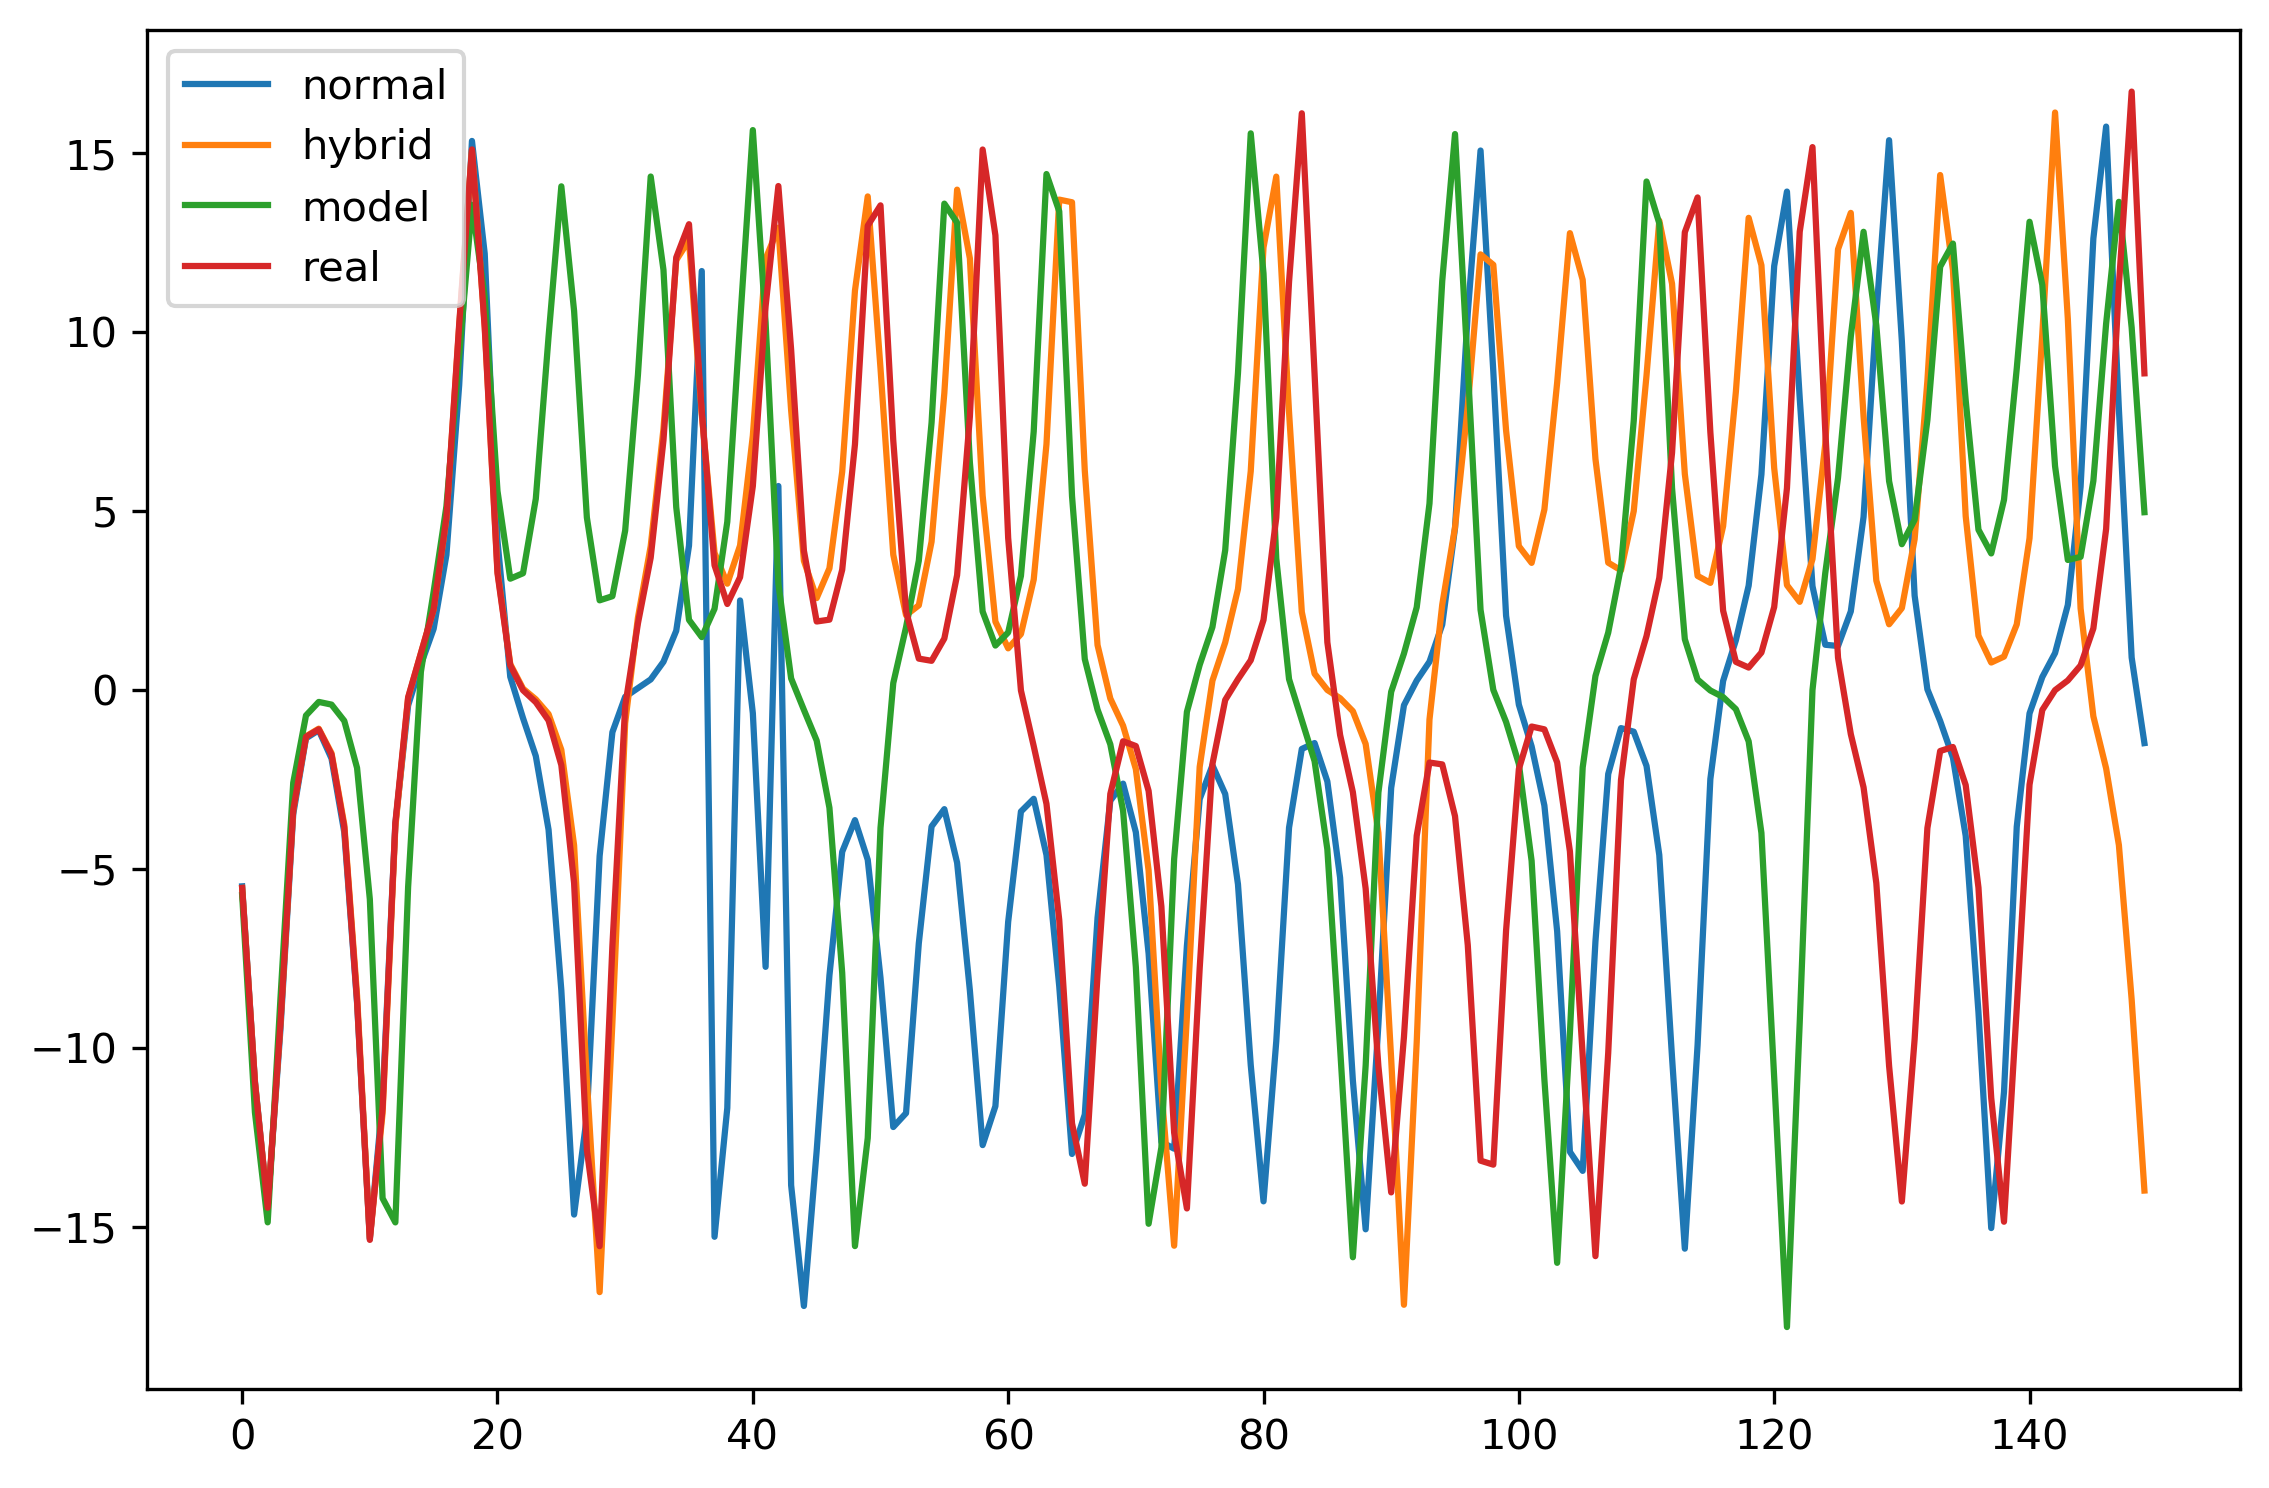

In [8]:
# Show single trajectories:

fig = plt.figure(figsize=(9, 6), dpi=300)
timeend = 150
part = 1
realization = 0
xyz = 0

n_i = 0
print("Res dim: ", n_dims[n_i])
if save_results:
    y_pred = results_normal_array[n_i, realization, part, :timeend, xyz]
    plt.plot(y_pred, label = "normal")
    y_pred = results_hybrid_array[n_i, realization, part, :timeend, xyz] 
    plt.plot(y_pred, label = "hybrid")
    y_pred = results_model_array[n_i, part, :timeend, xyz]
    plt.plot(y_pred, label = "model")
    plt.plot(x_pred_list[part][pre_pred_sync_steps+1:timeend+pre_pred_sync_steps+1, xyz], label = "real")
else:
    y_test, y_pred = (results_normal[realization, part, i, :timeend, xyz] for i in (0,1))
    plt.plot(y_pred, label = "normal")
    y_test, y_pred = (results_hybrid[realization, part, i, :timeend, xyz] for i in (0,1))
    plt.plot(y_pred, label = "hybrid")
    y_test, y_pred = (results_model[part, i, :timeend, xyz] for i in (0,1))
    plt.plot(y_pred, label = "model")


plt.legend()

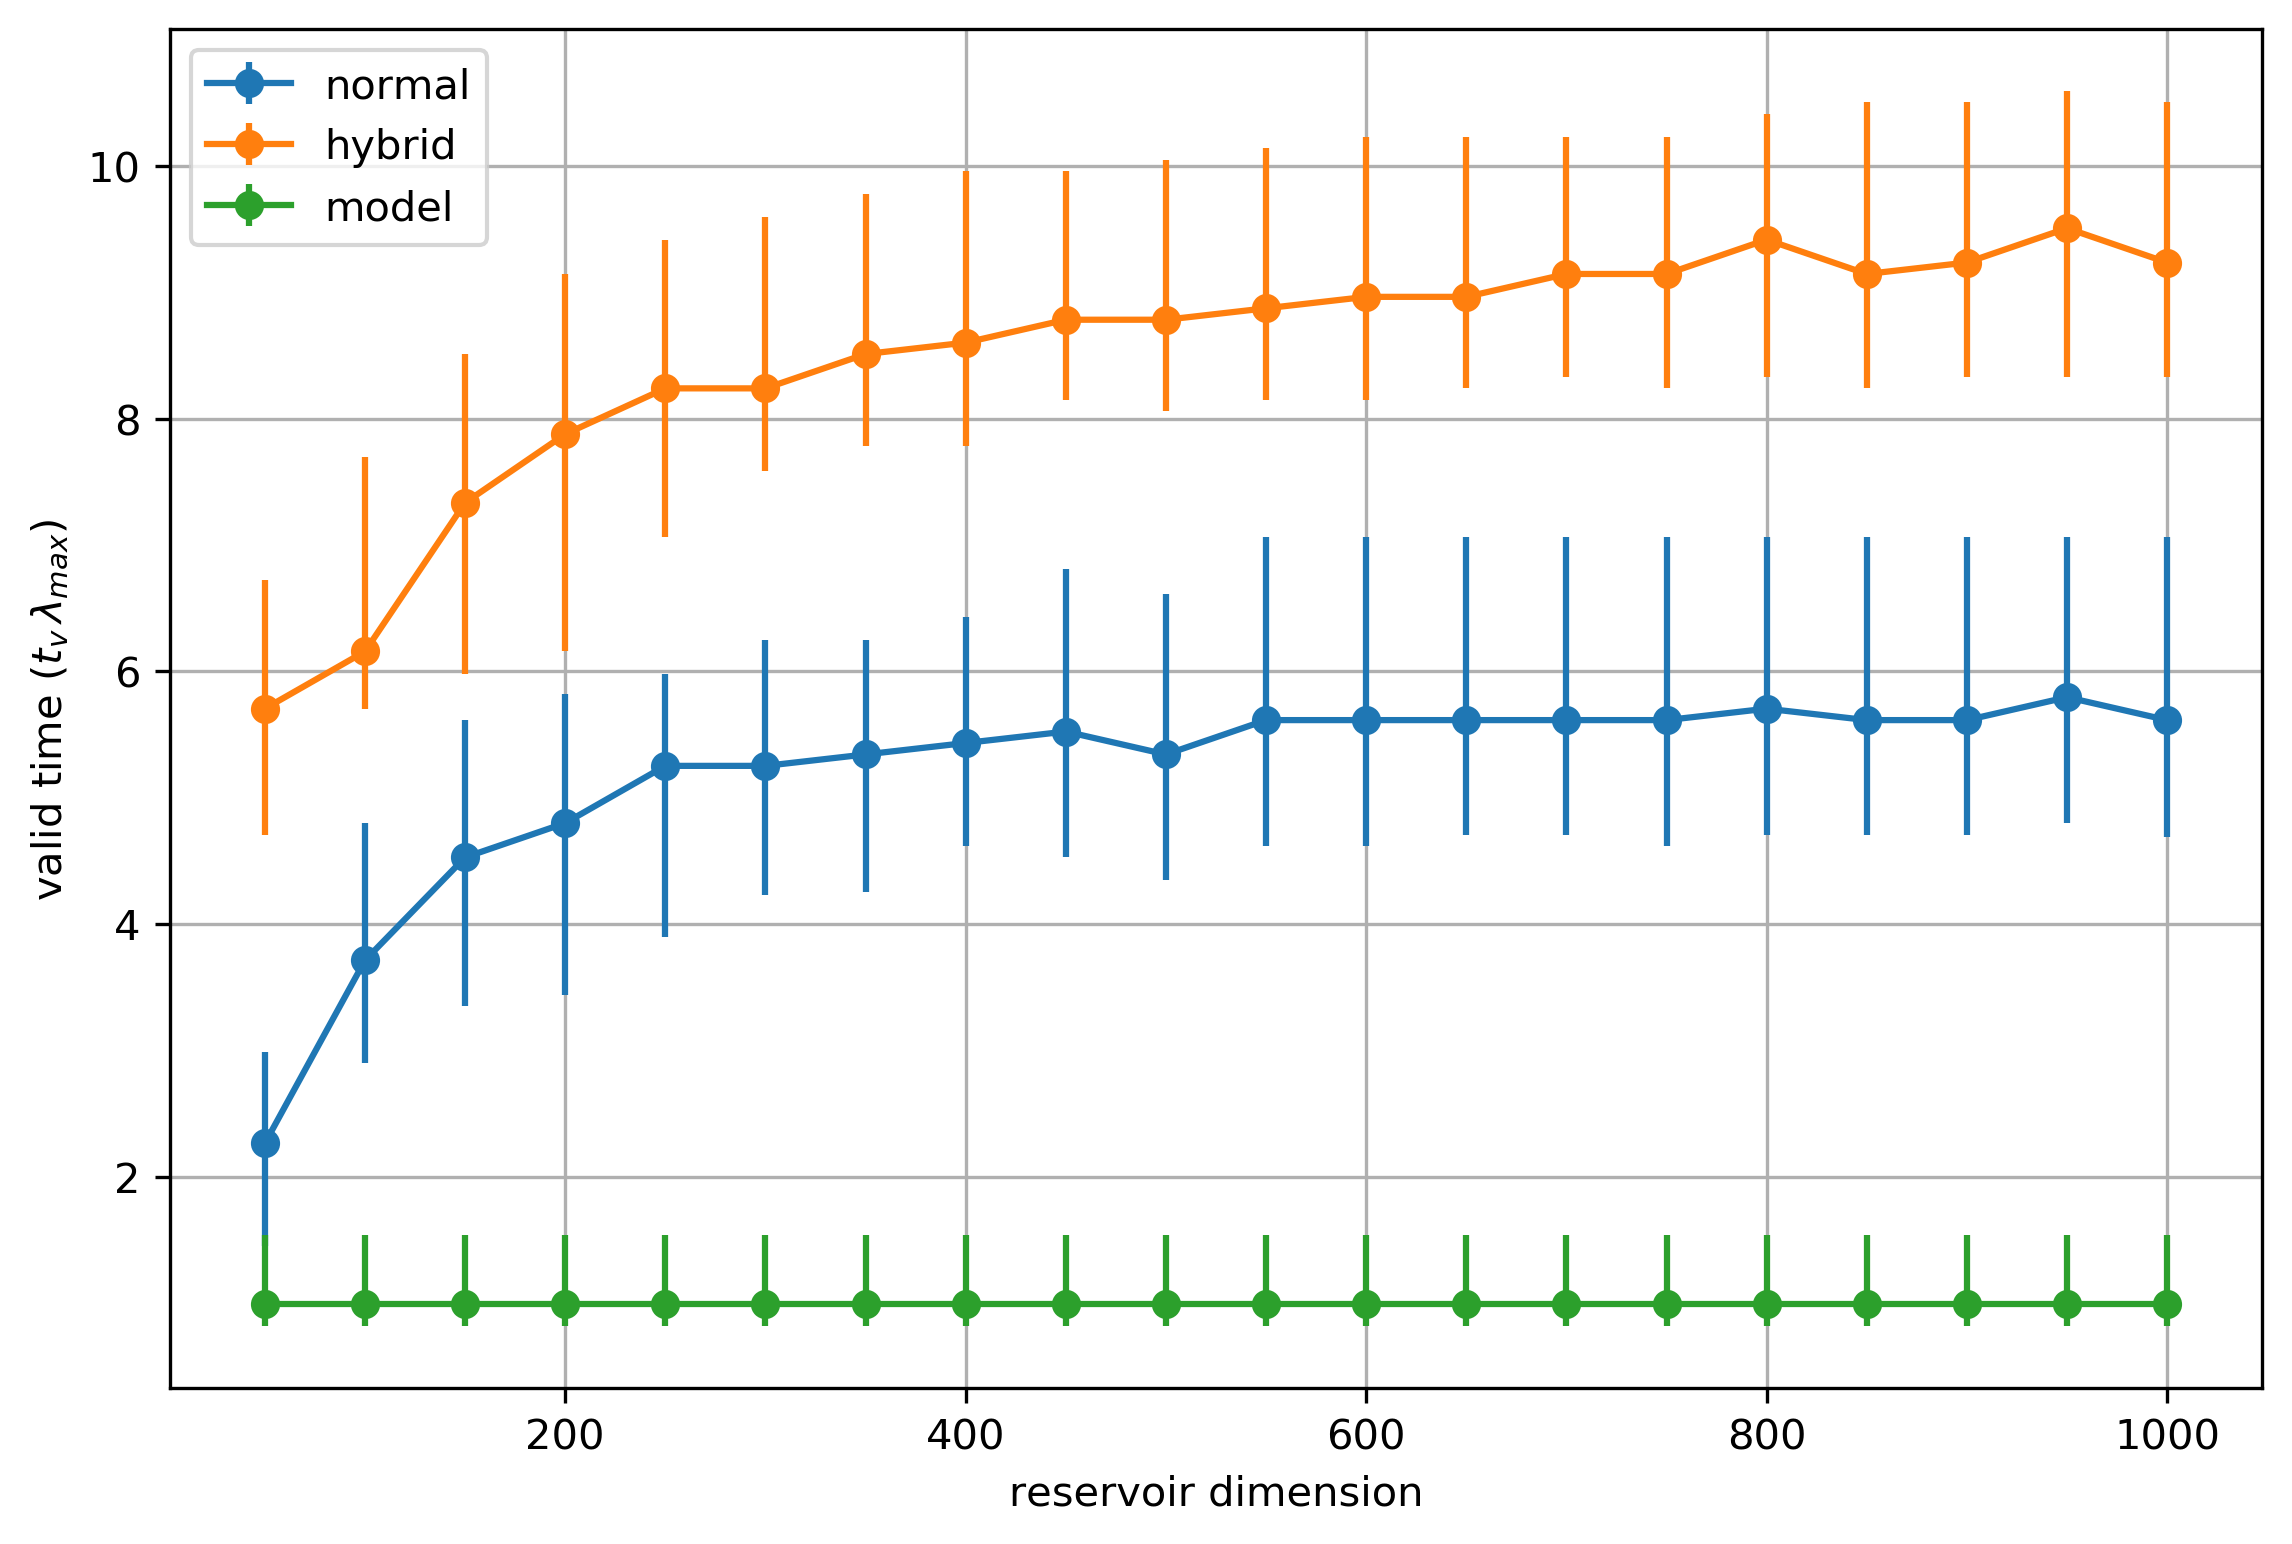

In [9]:
valid_times_dict = {}
valid_times_dict["normal"] = valid_times_results_normal
valid_times_dict["hybrid"] = valid_times_results_hybrid
valid_times_dict["model"] = valid_times_results_model

fig = plt.figure(figsize=(9, 6), dpi=300)
ax = fig.add_subplot(1, 1, 1)

scale = dt*0.9056

for key, val in valid_times_dict.items():
    if len(val.shape) == 3:
        axis = (-1, -2)
    elif len(val.shape) == 2:
        axis = -1
    
    median_list = np.median(val, axis = axis)*scale
    fist_quartile_list = np.quantile(val, 0.25, axis= axis)*scale
    third_quartile_list = np.quantile(val, 0.75, axis= axis)*scale
    ax.errorbar(n_dims, median_list, yerr=[median_list - fist_quartile_list, third_quartile_list - median_list], fmt='-o', label = key)

ax.set_xlabel("reservoir dimension")
ax.set_ylabel("valid time $(t_v\, \lambda_{max})$")
# ax.errorbar(n_dims, median_array_model, yerr=[lower_error_model, upper_error_model], fmt='-o', label = "model")    
plt.grid()
plt.legend()

## Experiment 2: Valid Time vs. Epsilon:

In [10]:
# Experiment parameters:
n_dim = 50
eps_list = np.linspace(0.004, 0.1, 25)
# eps_list = eps_list[-2:]
print("epsilon sweep: ", eps_list)

epsilon sweep:  [0.004 0.008 0.012 0.016 0.02  0.024 0.028 0.032 0.036 0.04  0.044 0.048
 0.052 0.056 0.06  0.064 0.068 0.072 0.076 0.08  0.084 0.088 0.092 0.096
 0.1  ]


In [11]:
# SKIP CELL IF YOU WANT TO LOAD DATA:

# normal and Hybrid RC and model simulation:
if save_results:
    results_normal_array_eps = np.zeros((eps_list.size, nr_of_reailzations, nr_of_time_intervals, predict_steps-1, 3))
    results_hybrid_array_eps = np.zeros((eps_list.size, nr_of_reailzations, nr_of_time_intervals, predict_steps-1, 3))
    results_model_array_eps = np.zeros((eps_list.size, nr_of_time_intervals, predict_steps-1, 3))


valid_times_results_normal_eps = np.zeros((eps_list.size, nr_of_reailzations, nr_of_time_intervals))
valid_times_results_hybrid_eps = np.zeros((eps_list.size, nr_of_reailzations, nr_of_time_intervals))
valid_times_results_model_eps = np.zeros((eps_list.size, nr_of_time_intervals))


print("=== Starting calculations ===")

print("=== RC calculation - normal ===")
# Normal RC:
results_normal = do_ens_experiment_rc(n_dim, model = "normal")
valid_times_normal = get_valid_times_rc(results_normal)

for i_e, eps in enumerate(eps_list):
    valid_times_results_normal_eps[i_e, :, :] = valid_times_normal
    
    print(f" ---- Starting experiment for eps = {eps} ----")

    # Model based:
    print("-.-.- Model Prediction -.-.-")
    results_model = do_ens_experiment_model(eps = eps)
    valid_times_model = get_valid_times_model(results_model)
    
    # Hybrid RC: 
    print("-.-.- Hybrid RC -.-.-")
    results_hybrid = do_ens_experiment_rc(n_dim, model = "hybrid", eps = eps)
    valid_times_hybrid = get_valid_times_rc(results_hybrid)
    
    if save_results:
        results_model_array_eps[i_e, :, :, :] = results_model[:, 1, :, :]
        results_hybrid_array_eps[i_e, :, :, :, :] = results_hybrid[:, :, 1, :, :]
        results_normal_array_eps[i_e, :, :, :, :] = results_normal[:, :, 1, :, :]
    
    valid_times_results_model_eps[i_e, :] = valid_times_model
    valid_times_results_hybrid_eps[i_e, :, :] = valid_times_hybrid

=== Starting calculations ===
=== RC calculation - normal ===
Realization: 1/32
Realization: 2/32
Realization: 3/32
Realization: 4/32
Realization: 5/32
Realization: 6/32
Realization: 7/32
Realization: 8/32
Realization: 9/32
Realization: 10/32
Realization: 11/32
Realization: 12/32
Realization: 13/32
Realization: 14/32
Realization: 15/32
Realization: 16/32
Realization: 17/32
Realization: 18/32
Realization: 19/32
Realization: 20/32
Realization: 21/32
Realization: 22/32
Realization: 23/32
Realization: 24/32
Realization: 25/32
Realization: 26/32
Realization: 27/32
Realization: 28/32
Realization: 29/32
Realization: 30/32
Realization: 31/32
Realization: 32/32
...getting valid times (RC)..:
Valid time realization: 1/32
Valid time realization: 2/32
Valid time realization: 3/32
Valid time realization: 4/32
Valid time realization: 5/32
Valid time realization: 6/32
Valid time realization: 7/32
Valid time realization: 8/32
Valid time realization: 9/32
Valid time realization: 10/32
Valid time realiz

Valid time realization: 23/32
Valid time realization: 24/32
Valid time realization: 25/32
Valid time realization: 26/32
Valid time realization: 27/32
Valid time realization: 28/32
Valid time realization: 29/32
Valid time realization: 30/32
Valid time realization: 31/32
Valid time realization: 32/32
 ---- Starting experiment for eps = 0.02 ----
-.-.- Model Prediction -.-.-
...getting valid times (Model)..:
-.-.- Hybrid RC -.-.-
Realization: 1/32
Realization: 2/32
Realization: 3/32
Realization: 4/32
Realization: 5/32
Realization: 6/32
Realization: 7/32
Realization: 8/32
Realization: 9/32
Realization: 10/32
Realization: 11/32
Realization: 12/32
Realization: 13/32
Realization: 14/32
Realization: 15/32
Realization: 16/32
Realization: 17/32
Realization: 18/32
Realization: 19/32
Realization: 20/32
Realization: 21/32
Realization: 22/32
Realization: 23/32
Realization: 24/32
Realization: 25/32
Realization: 26/32
Realization: 27/32
Realization: 28/32
Realization: 29/32
Realization: 30/32
Realizat

Valid time realization: 11/32
Valid time realization: 12/32
Valid time realization: 13/32
Valid time realization: 14/32
Valid time realization: 15/32
Valid time realization: 16/32
Valid time realization: 17/32
Valid time realization: 18/32
Valid time realization: 19/32
Valid time realization: 20/32
Valid time realization: 21/32
Valid time realization: 22/32
Valid time realization: 23/32
Valid time realization: 24/32
Valid time realization: 25/32
Valid time realization: 26/32
Valid time realization: 27/32
Valid time realization: 28/32
Valid time realization: 29/32
Valid time realization: 30/32
Valid time realization: 31/32
Valid time realization: 32/32
 ---- Starting experiment for eps = 0.04000000000000001 ----
-.-.- Model Prediction -.-.-
...getting valid times (Model)..:
-.-.- Hybrid RC -.-.-
Realization: 1/32
Realization: 2/32
Realization: 3/32
Realization: 4/32
Realization: 5/32
Realization: 6/32
Realization: 7/32
Realization: 8/32
Realization: 9/32
Realization: 10/32
Realization: 

Realization: 29/32
Realization: 30/32
Realization: 31/32
Realization: 32/32
...getting valid times (RC)..:
Valid time realization: 1/32
Valid time realization: 2/32
Valid time realization: 3/32
Valid time realization: 4/32
Valid time realization: 5/32
Valid time realization: 6/32
Valid time realization: 7/32
Valid time realization: 8/32
Valid time realization: 9/32
Valid time realization: 10/32
Valid time realization: 11/32
Valid time realization: 12/32
Valid time realization: 13/32
Valid time realization: 14/32
Valid time realization: 15/32
Valid time realization: 16/32
Valid time realization: 17/32
Valid time realization: 18/32
Valid time realization: 19/32
Valid time realization: 20/32
Valid time realization: 21/32
Valid time realization: 22/32
Valid time realization: 23/32
Valid time realization: 24/32
Valid time realization: 25/32
Valid time realization: 26/32
Valid time realization: 27/32
Valid time realization: 28/32
Valid time realization: 29/32
Valid time realization: 30/32
Va

Realization: 8/32
Realization: 9/32
Realization: 10/32
Realization: 11/32
Realization: 12/32
Realization: 13/32
Realization: 14/32
Realization: 15/32
Realization: 16/32
Realization: 17/32
Realization: 18/32
Realization: 19/32
Realization: 20/32
Realization: 21/32
Realization: 22/32
Realization: 23/32
Realization: 24/32
Realization: 25/32
Realization: 26/32
Realization: 27/32
Realization: 28/32
Realization: 29/32
Realization: 30/32
Realization: 31/32
Realization: 32/32
...getting valid times (RC)..:
Valid time realization: 1/32
Valid time realization: 2/32
Valid time realization: 3/32
Valid time realization: 4/32
Valid time realization: 5/32
Valid time realization: 6/32
Valid time realization: 7/32
Valid time realization: 8/32
Valid time realization: 9/32
Valid time realization: 10/32
Valid time realization: 11/32
Valid time realization: 12/32
Valid time realization: 13/32
Valid time realization: 14/32
Valid time realization: 15/32
Valid time realization: 16/32
Valid time realization: 1

Valid time realization: 29/32
Valid time realization: 30/32
Valid time realization: 31/32
Valid time realization: 32/32
 ---- Starting experiment for eps = 0.096 ----
-.-.- Model Prediction -.-.-
...getting valid times (Model)..:
-.-.- Hybrid RC -.-.-
Realization: 1/32
Realization: 2/32
Realization: 3/32
Realization: 4/32
Realization: 5/32
Realization: 6/32
Realization: 7/32
Realization: 8/32
Realization: 9/32
Realization: 10/32
Realization: 11/32
Realization: 12/32
Realization: 13/32
Realization: 14/32
Realization: 15/32
Realization: 16/32
Realization: 17/32
Realization: 18/32
Realization: 19/32
Realization: 20/32
Realization: 21/32
Realization: 22/32
Realization: 23/32
Realization: 24/32
Realization: 25/32
Realization: 26/32
Realization: 27/32
Realization: 28/32
Realization: 29/32
Realization: 30/32
Realization: 31/32
Realization: 32/32
...getting valid times (RC)..:
Valid time realization: 1/32
Valid time realization: 2/32
Valid time realization: 3/32
Valid time realization: 4/32
Va

In [12]:
# SKIP IF YOU WANT TO LOAD DATA:
# SAVE data:
pre_path = r"C:\Users\Dennis\Documents\FILES&INFO\WISSEN\STUDIUM\Master LMU\Masterthesis\Simulations/"
if save_results:
    np.save(pre_path + r"results_model_array_eps" , results_model_array_eps)
    np.save(pre_path + r"results_hybrid_array_eps" , results_hybrid_array_eps)
    np.save(pre_path + r"results_normal_array_eps" , results_normal_array_eps)
    
np.save(pre_path + r"valid_times_results_normal_eps" , valid_times_results_normal_eps)
np.save(pre_path + r"valid_times_results_hybrid_eps" , valid_times_results_hybrid_eps)
np.save(pre_path + r"valid_times_results_model_eps" , valid_times_results_model_eps)

In [ ]:
# LOAD data:
pre_path = r"C:\Users\Dennis\Documents\FILES&INFO\WISSEN\STUDIUM\Master LMU\Masterthesis\Simulations/"
if save_results:
    results_model_array_eps = np.load(pre_path + r"results_model_array_eps.npy")
    results_hybrid_array_eps = np.load(pre_path + r"results_hybrid_array_eps.npy")
    results_normal_array_eps = np.load(pre_path + r"results_normal_array_eps.npy")
    
valid_times_results_normal_eps = np.load(pre_path + r"valid_times_results_normal_eps.npy")
valid_times_results_hybrid_eps = np.load(pre_path + r"valid_times_results_hybrid_eps.npy")
valid_times_results_model_eps = np.load(pre_path + r"valid_times_results_model_eps.npy")

epsilon:  0.004


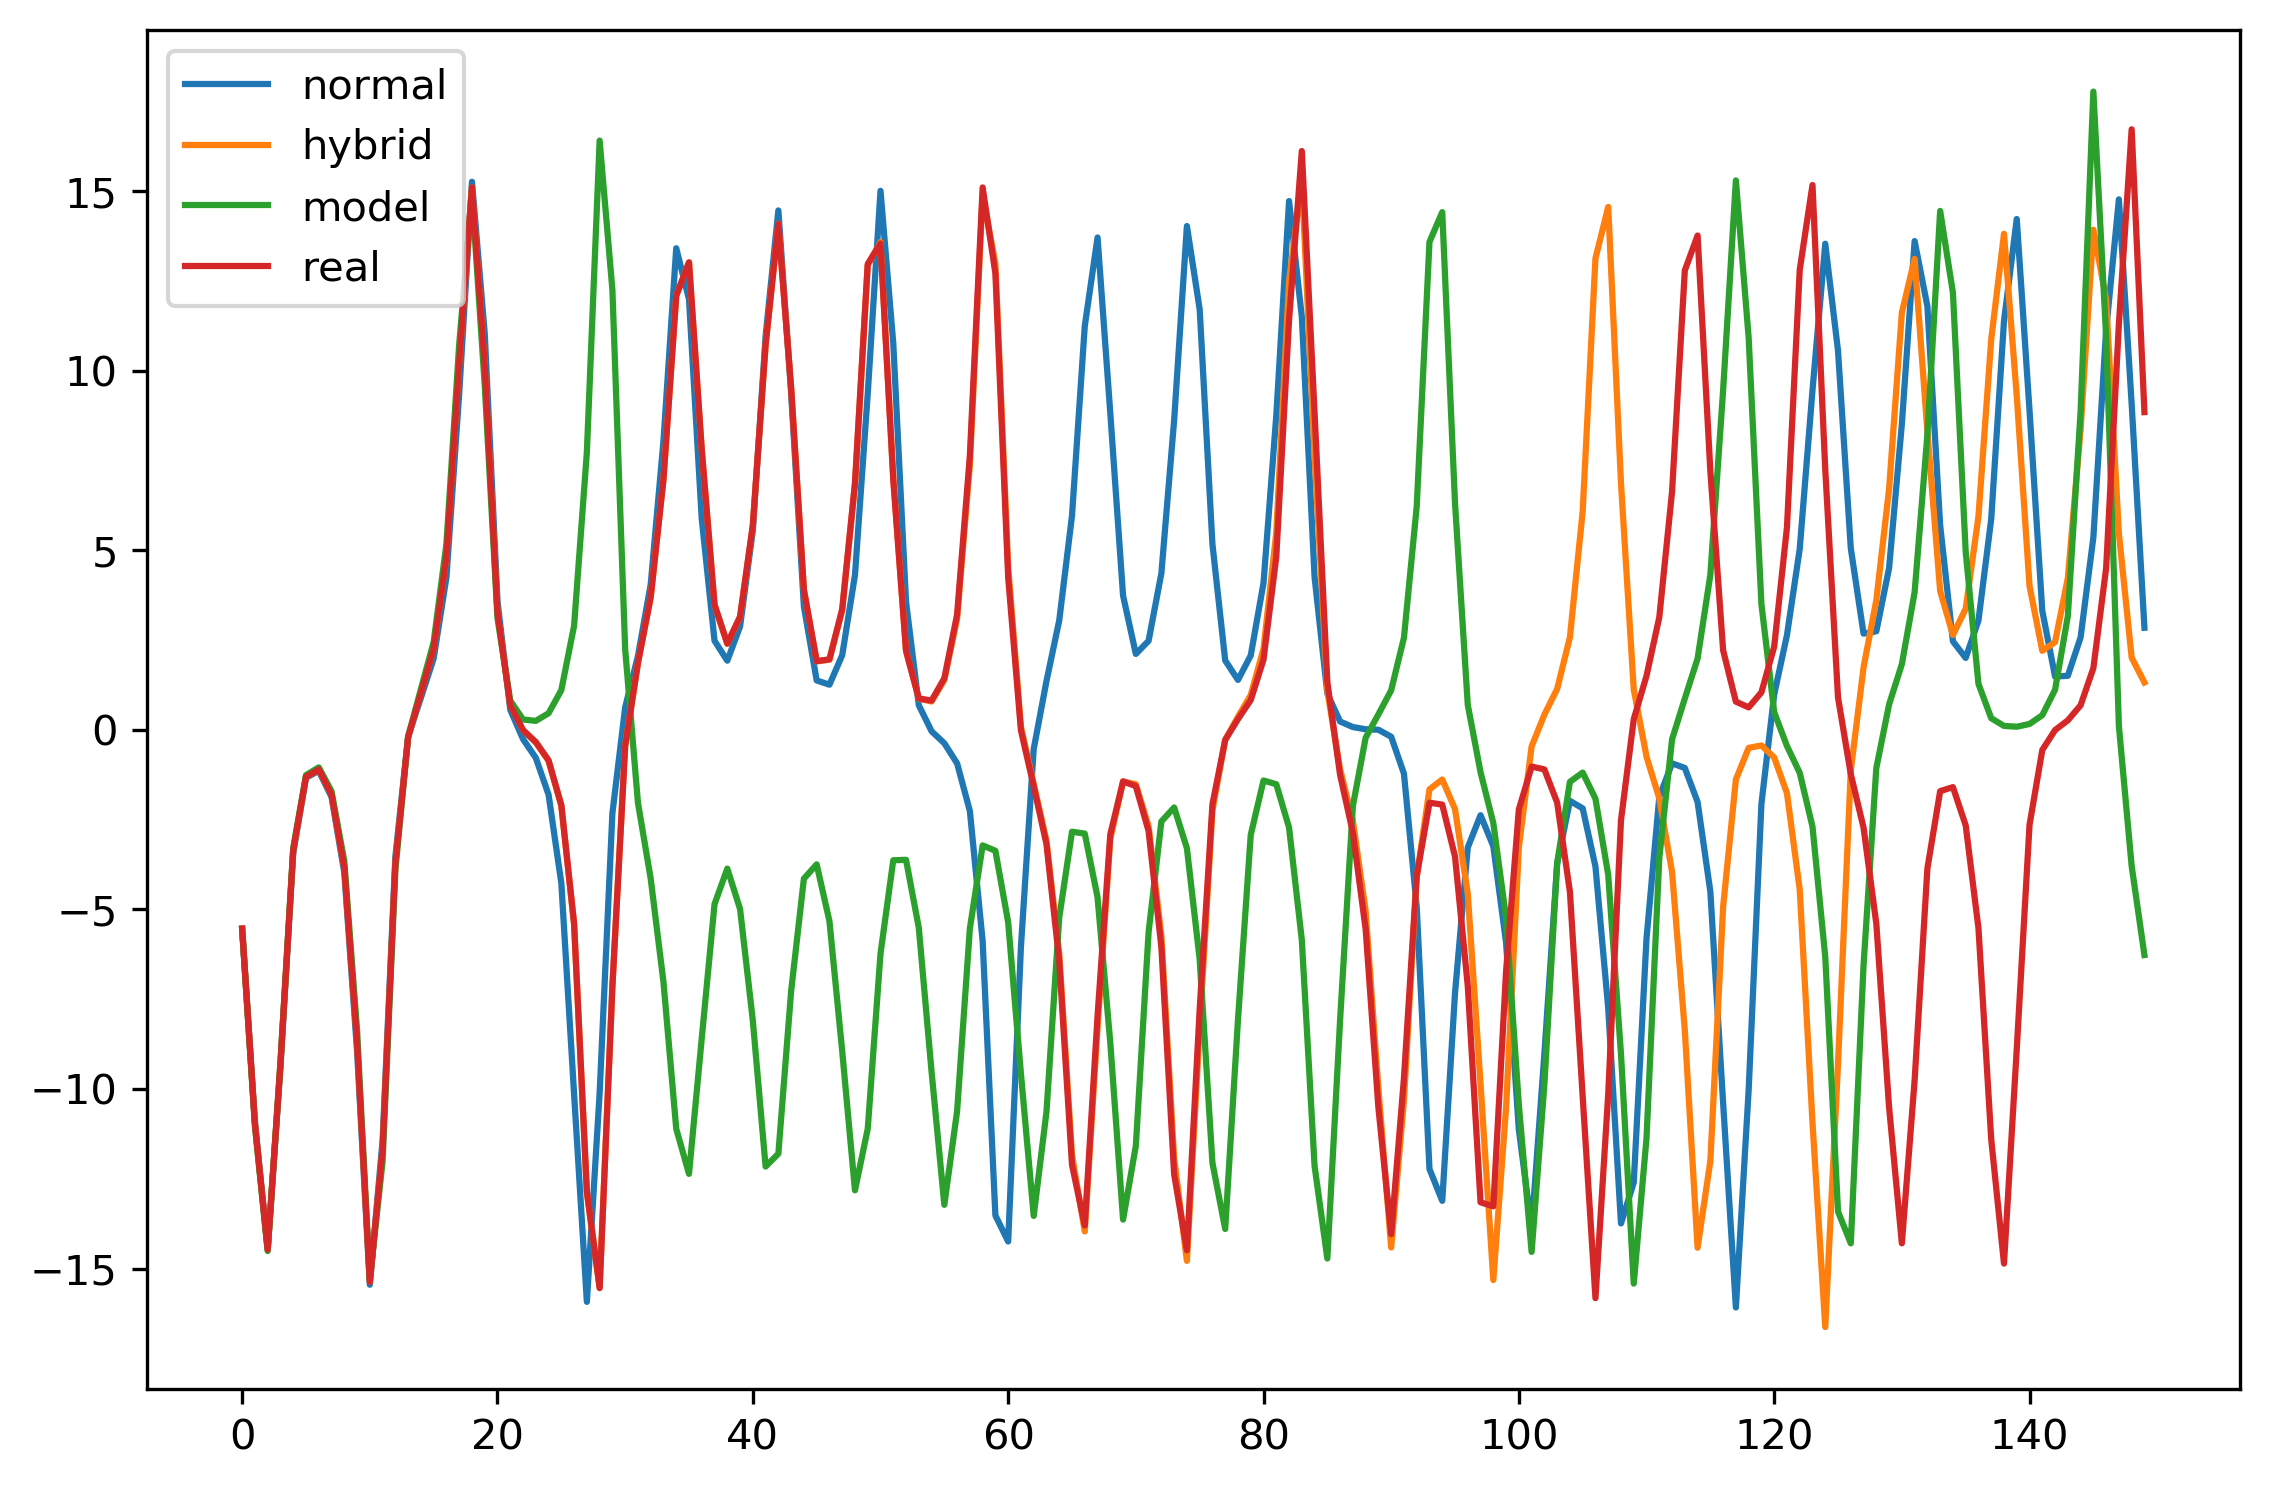

In [13]:
# Show single trajectories:

fig = plt.figure(figsize=(9, 6), dpi=300)
timeend = 150
part = 1
realization = 0
xyz = 0

e_i = 0
print("epsilon: ", eps_list[e_i])
if save_results:
    y_pred = results_normal_array_eps[e_i, realization, part, :timeend, xyz]
    plt.plot(y_pred, label = "normal")
    y_pred = results_hybrid_array_eps[e_i, realization, part, :timeend, xyz] 
    plt.plot(y_pred, label = "hybrid")
    y_pred = results_model_array_eps[e_i, part, :timeend, xyz]
    plt.plot(y_pred, label = "model")
    plt.plot(x_pred_list[part][pre_pred_sync_steps+1:timeend+pre_pred_sync_steps+1, xyz], label = "real")
else:
    y_test, y_pred = (results_normal[realization, part, i, :timeend, xyz] for i in (0,1))
    plt.plot(y_pred, label = "normal")
    y_test, y_pred = (results_hybrid[realization, part, i, :timeend, xyz] for i in (0,1))
    plt.plot(y_pred, label = "hybrid")
    y_test, y_pred = (results_model[part, i, :timeend, xyz] for i in (0,1))
    plt.plot(y_pred, label = "model")

plt.legend()

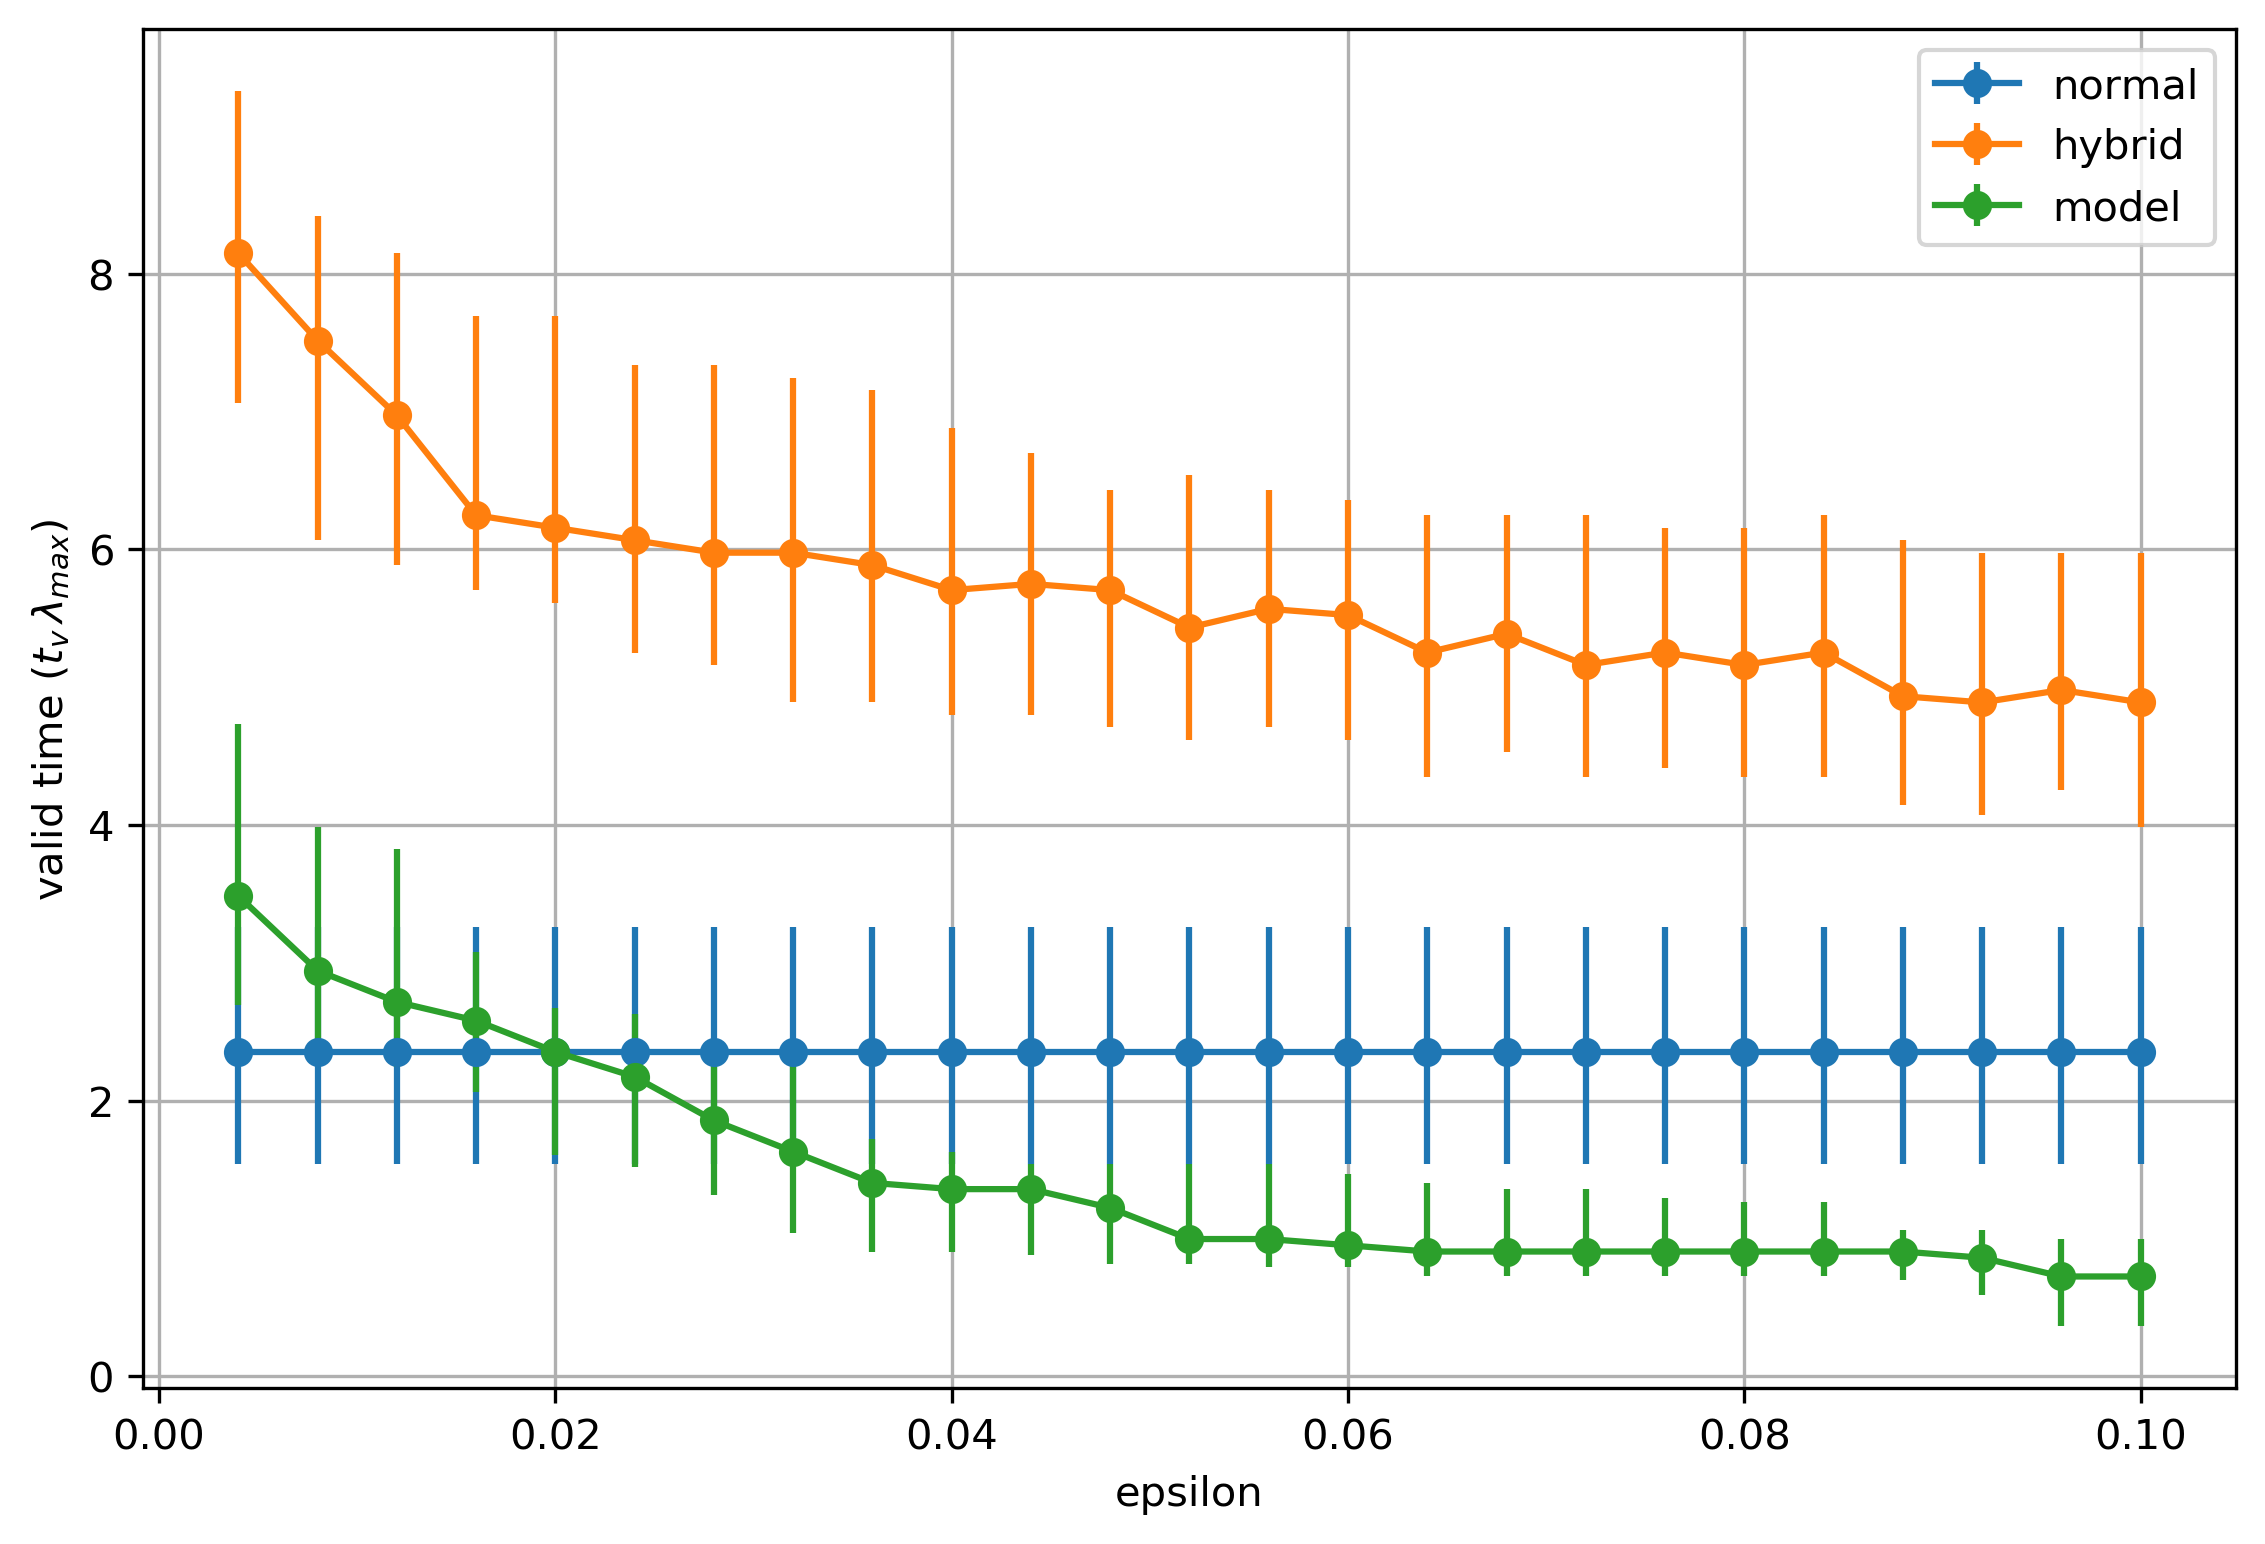

In [15]:
valid_times_dict = {}
valid_times_dict["normal"] = valid_times_results_normal_eps
valid_times_dict["hybrid"] = valid_times_results_hybrid_eps
valid_times_dict["model"] = valid_times_results_model_eps

fig = plt.figure(figsize=(9, 6), dpi=300)
ax = fig.add_subplot(1, 1, 1)

scale = dt*0.9056

for key, val in valid_times_dict.items():
    if len(val.shape) == 3:
        axis = (-1, -2)
    elif len(val.shape) == 2:
        axis = -1
    
    median_list = np.median(val, axis = axis)*scale
    fist_quartile_list = np.quantile(val, 0.25, axis= axis)*scale
    third_quartile_list = np.quantile(val, 0.75, axis= axis)*scale
    ax.errorbar(eps_list, median_list, yerr=[median_list - fist_quartile_list, third_quartile_list - median_list], fmt='-o', label = key)

ax.set_xlabel("epsilon")
ax.set_ylabel("valid time $(t_v\, \lambda_{max})$")
# ax.errorbar(n_dims, median_array_model, yerr=[lower_error_model, upper_error_model], fmt='-o', label = "model")    
plt.grid()
plt.legend()

# SAVE DATA:

In [ ]:
# Save Data:
np.save(r"C:\Users\Dennis\Documents\FILES&INFO\WISSEN\STUDIUM\Master LMU\Masterthesis\Simulations\valid_times_results_hybrid" , valid_times_results_hybrid)

# LOAD DATA:

In [ ]:
valid_times_results_hybrid = np.load(r"C:\Users\Dennis\Documents\FILES&INFO\WISSEN\STUDIUM\Master LMU\Masterthesis\Simulations\valid_times_results_hybrid.npy")

valid_times_results_normal = np.load(r"C:\Users\Dennis\Documents\FILES&INFO\WISSEN\STUDIUM\Master LMU\Masterthesis\Simulations\valid_times_results_normal.npy")

# TEST:

In [ ]:
# normal and Hybrid RC:


valid_times_results_eps_model = np.zeros((eps_list.size, nr_of_reailzations, nr_of_time_intervals))
valid_times_results_eps_hybrid = np.zeros((eps_list.size, nr_of_reailzations, nr_of_time_intervals))

print("=== Starting RC calculations ===")

for i_e, eps in enumerate(eps_list):
    print(f" ---- Starting experiment for eps = {eps} ----")
    print("-.-.- Model Prediction -.-.-")
    
    
    print("-.-.- Hybrid RC -.-.-")
    results_hybrid = do_ens_experiment(n_dim=50, model = "hybrid", eps = eps)
    valid_times_hybrid = get_valid_times(results_hybrid)
    
    valid_times_results_eps_model[i_e, :, :] = valid_times_model
    valid_times_results_eps_hybrid[i_e, :, :] = valid_times_hybrid

In [ ]:
# Only Modelbased:

model_pred = variation_of_lorenz_model(dt, eps2 = eps)

y_pred_results_model = np.zeros((nr_of_time_intervals, predict_steps, 3))
for i, x_pred in enumerate(x_pred_list):
    x_pred = x_pred[pre_pred_sync_steps:, :]
    y_pred = np.zeros(x_pred.shape)
    x_0 = x_pred[0]
    x_i = x_0
    y_pred_results_model[i, 0, :] = x_i
    for j in range(1, predict_steps):
        x_i = model_pred(x_i)
        y_pred_results_model[i, j, :] = x_i

# plt.plot(y_pred_results_model[0, :, 0])
error_results_model = np.zeros((nr_of_time_intervals, predict_steps-1))
valid_times_result_model = np.zeros(nr_of_time_intervals)

for i in range(nr_of_time_intervals):
    y_pred, y_test = y_pred_results_model[i, :, :], x_pred_list[i][pre_pred_sync_steps+1:]
    error_array = Error(y_pred, y_test)
    error_results_model[i, :] = error_array
    valid_times_result_model[i] = get_valid_time_index(error_array, f)

print(valid_times_result_model.shape)

first_quantile_model = np.quantile(valid_times_result_model, 0.25)
median_model = np.median(valid_times_result_model)
third_quantile_model = np.quantile(valid_times_result_model, 0.75)

median_array_model = np.array([median_model, ]*n_dims.size)
lower_error_model = median_array_model - first_quantile_model
upper_error_model = third_quantile_model - median_array_model

In [ ]:
plt.figure(figsize = (9, 6))
timeend = 100
part = 0
xyz = 0

y_pred = y_pred_results_model[part, :timeend, xyz]
x_pred = x_pred_list[part][pre_pred_sync_steps:pre_pred_sync_steps+timeend, xyz]
plt.plot(y_pred)
plt.plot(x_pred)

In [ ]:
r = np.ones((10, 3))*2
print(r.shape)
r[1::2, :] = r[1::2, :]**2
print(r.shape)

# OLD

In [ ]:
Error_list = np.zeros((nr_of_reailzations, nr_of_time_intervals, predict_steps-1))
valid_time_list = np.zeros((nr_of_reailzations, nr_of_time_intervals)) 
for i in range(nr_of_reailzations):
    print(f"Realization: {i+1}/{nr_of_reailzations}" )
    for j in range(nr_of_time_intervals):
        y_test, y_pred = results[i, j, 0, :, :], results[i, j, 1, :, :]
        error_array = Error(y_pred, y_test)
        valid_time_index = get_valid_time_index(error_array, f)
        Error_list[i, j, :] = error_array
        valid_time_list[i, j] = valid_time_index

In [ ]:
x = valid_time_list.flatten()
plt.hist(x, bins = 15)

In [ ]:
fig2 = plt.figure(figsize=(9, 6), dpi=300)
ax2 = fig2.add_subplot(1, 1, 1)
ax2.plot(y_test[:200, 0], color='blue', label='simulation')
ax2.plot(y_pred[:200, 0], color='orange', linestyle='--', label='pred')


start = y_test[0]
ax2.plot(start[0], color='black', linestyle='', marker='o', 
         label='starting point')

ax2.set_title("X-Coordinates of Simulation and Prediction")
ax2.set_xlabel('time steps')
ax2.set_ylabel('x')
plt.legend()
plt.show()

In [ ]:
n_dim = 50

results = np.zeros((nr_of_reailzations, nr_of_time_intervals, 2, predict_steps-1, 3))

for i in range(nr_of_reailzations):
    print(f"Realization: {i+1}/{nr_of_reailzations}" )
    esn = rescomp.esn.ESNWrapper()
    esn.create_network(n_dim = n_dim, n_rad=p, n_avg_deg=avg_deg, n_type_flag="erdos_renyi") # should be directed
    esn.train(x_train = x_train, sync_steps = pre_train_sync_steps, reg_param=beta, w_in_scale=sigma,
              w_in_sparse = w_in_sparse, w_in_ordered=w_in_ordered, act_fct_flag=act_fct_flag, 
             w_out_fit_flag = w_out_fit_flag) #should have different w_out_fit_flat

    for j in range(nr_of_time_intervals):
        x_pred = x_pred_list[j]
        y_pred, y_test = esn.predict(x_pred = x_pred, sync_steps=pre_pred_sync_steps)
        results[i, j, 0, :, :] = y_test
        results[i, j, 1, :, :] = y_pred

# TODO:

- Add even and odd mixed $r$ and $r^2$ to code
- Add directed random graph to code

# OLD

In [ ]:
#Create artificially "wrong" model by changing the system parameters:
eps1 = 0.0
eps2 = 0.1
eps3 = 0.0
model = lambda x: rescomp.simulations._normal_lorenz(x, sigma=10*(1+eps1), rho=28*(1+eps2), beta=8/3*(1+eps3))

# model_pred = lambda x: x + model(x)*dt
model_pred = lambda x: rescomp.simulations._runge_kutta(model, dt, x)

# test it:
x = np.zeros((simulation_time_steps, 3))

x[0] = starting_point
for i in range(1, simulation_time_steps):
    x_i = x[i-1]
    x[i] = model_pred(x_i)